<a href="https://colab.research.google.com/github/sun-gif/takehomechanllenge2/blob/master/relax_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files

uploaded = files.upload()


Saving takehome_user_engagement.csv to takehome_user_engagement (1).csv
Saving takehome_users.csv to takehome_users (1).csv


In [6]:
import pandas as pd
import io
user_engament= pd.read_csv(io.BytesIO(uploaded['takehome_user_engagement.csv']))
user= pd.read_csv(io.BytesIO(uploaded['takehome_users.csv']),encoding='latin-1')

In [7]:
user_engament.head()
user_engament.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:

user_engament['time_stamp']=pd.to_datetime(user_engament.time_stamp)
user_engament['date']=user_engament.time_stamp.map(lambda x:x.date())

df=user_engament.sort_values(['user_id','date'])


len(df.groupby('user_id')['date'].unique())
len(df.groupby('user_id')['date'])

8823

there is no duplicate date for each user

In [10]:
from datetime import timedelta
# define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_days(df, days=7, logins=3):
    
    
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

Defining   an      "adopted   user"      as   a   user   who         has   logged   into   the   product   on   three   separate  days   in   at   least   one   seven­day   period  . 

In [11]:

# run the function on all users
adopted = df.groupby('user_id').apply(logins_days)
adopted.name = 'adopted_user'

In [12]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [13]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [14]:
user_df=pd.merge(adopted,user,left_on='user_id',right_on='object_id')
user_df.head()

#user_df['adopted']=0
#user_df.loc[user_df['adopted_user'],'adopted']=1


,adopted_user,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,False,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,True,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,False,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,False,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,False,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


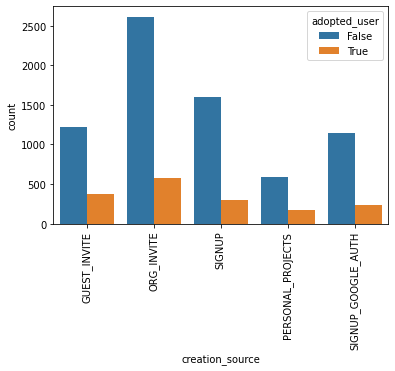

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.countplot(x='creation_source', data=user_df, hue='adopted_user')
_ = plt.xticks(rotation=90)

#the Plot looks like Guest_invite is better than Org_invited , we can test it with Chi2 test

In [ ]:


# chi2 test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(user_df['creation_source'], user_df['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


P value is less than 0.05, there is some difference in statstics view

In [16]:

# how much diff for creation_source
user_df.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

GUEST_INVITE AND PERSONAL_PROJECTS are slightly higher than others,that make sense, since if a person use it for personal reason, they usually have more passion on it 

In [17]:
# check mailing list and marketing drip
user_df.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [18]:
user_df.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [19]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[df[col]==1, target]
    opted_out = df.loc[df[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(user_df, 'opted_in_to_mailing_list')


For opted_in_to_mailing_list, z = 0.7029779128148235, p = 0.4820695142048762


In [20]:
z_test(user_df, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940264, p = 0.6870022995069656


z_test shows there is no significent difference  between users who signed up or not for mailing list and marketing drip.


In [22]:
user_df['invited_by_user_id'].value_counts().head()

4612.0     10
11770.0     9
2308.0      9
1525.0      8
6808.0      8
Name: invited_by_user_id, dtype: int64

In [21]:
user_df['org_id'].value_counts().head()

0    228
1    172
2    150
3    125
4    122
Name: org_id, dtype: int64

Quick check on the organizations with most users and users who sent out most invites.
There were likely too many organizations and user invites to model. not much useful information provided, can drop later

In [23]:

# create a feature of log_age
# convert both time features into datetime
user_df['creation_time'] = pd.to_datetime(
    user_df['creation_time'], format='%Y-%m-%d %H:%M:%S')
user_df['last_session_creation_time'] = pd.to_datetime(
    user_df['last_session_creation_time'], unit='s')
# calculate user log_age, defined as number of days between account creation and last use
user_df['log_age'] = user_df['last_session_creation_time'] - user_df['creation_time']
user_df['log_age'] = user_df['log_age'].dt.days
# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(user_df['creation_time'])
user_df['account_age'] = latest - user_df['creation_time']
user_df['account_age'] = user_df['account_age'].dt.days
# drop the two original columns


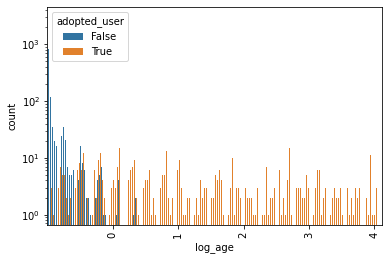

In [24]:

ax=sns.countplot('log_age', hue='adopted_user',data=user_df)
ax=plt.xticks(rotation=90)
#ax=plt.ylim(0, 500)
plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plt.xticks([100, 200, 300, 400,500])
plt.yscale('log')


it looks like larger log_age( people use it for a long time) tend to be adopted(use it more often)

In [26]:
user_df = user_df.drop(['creation_time', 'last_session_creation_time','name','email','org_id','invited_by_user_id'], axis=1)


drop  features with little information or replaced by other features

Check correlations between features


In [27]:
corr_matrix = user_df.corr()
corr_matrix

,adopted_user,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,log_age,account_age
adopted_user,1.000000,0.003676,0.007485,0.004290,0.777844,0.108555
object_id,0.003676,1.000000,-0.034920,-0.028916,-0.008526,-0.021656
opted_in_to_mailing_list,0.007485,-0.034920,1.000000,0.488219,0.005609,-0.003143
enabled_for_marketing_drip,0.004290,-0.028916,0.488219,1.000000,0.007417,-0.003440
log_age,0.777844,-0.008526,0.005609,0.007417,1.000000,0.262308
account_age,0.108555,-0.021656,-0.003143,-0.003440,0.262308,1.000000


In [28]:
corr_matrix[(abs(corr_matrix) >= 0.50) & (abs(corr_matrix) < 1.0)]

,adopted_user,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,log_age,account_age
adopted_user,NaN,NaN,NaN,NaN,0.777844,NaN
object_id,NaN,NaN,NaN,NaN,NaN,NaN
opted_in_to_mailing_list,NaN,NaN,NaN,NaN,NaN,NaN
enabled_for_marketing_drip,NaN,NaN,NaN,NaN,NaN,NaN
log_age,0.777844,NaN,NaN,NaN,NaN,NaN
account_age,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
user_df.isnull().sum()

adopted_user                  0
object_id                     0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
log_age                       0
account_age                   0
dtype: int64

In [30]:
user_df.head()

,adopted_user,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,log_age,account_age
0,False,1,GUEST_INVITE,1,0,0,38
1,True,2,ORG_INVITE,0,0,136,196
2,False,3,ORG_INVITE,0,0,0,437
3,False,4,GUEST_INVITE,0,0,1,374
4,False,5,GUEST_INVITE,0,0,5,498


Encoding catergorical feature

In [31]:
user_df = pd.get_dummies(user_df, columns = ['creation_source'])

In [32]:

X = user_df.drop(['adopted_user'],axis = 1)
y = user_df['adopted_user']

In [33]:

# split data to training dataset and testing dataset
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,y,train_size=0.80, test_size = 0.2, random_state = 4)

here we need resolve an binary classification problem. I Will use LogisticRegression  since it is very efficient ,easy to implement and highly interpretable.
we already do drop the unrelated or corelatted features.
that will imporve the performce of lg model
we will use accuary score as our evaluation metrics



In [34]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(solver='liblinear')

# Fit the model on the trainng data.
clf.fit(train_x, train_y)

# Print the accuracy from the testing data.
print(accuracy_score(test_y, clf.predict(test_x)))

0.9535410764872522


In [35]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1., 10.]

# Hyper-parameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'C':Cs}
cv_grid = GridSearchCV(clf, parameters, cv=5, scoring=make_scorer(accuracy_score), iid=True)
cv_grid.fit(train_x, train_y)
print(cv_grid.best_params_, cv_grid.best_score_)
print(accuracy_score(cv_grid.predict(test_x), test_y))

{'C': 0.1} 0.9606120714083309
0.9535410764872522


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [36]:

# Get Best Estimator Coefficients
cv_grid.best_estimator_.coef_

array([[-0.00034776, -0.06943301, -0.04262499,  0.05957864, -0.00641147,
        -0.05312427, -0.10856455, -0.01516018, -0.07154483, -0.04940607]])

In [37]:
lr_best_params = dict(zip(X.columns.tolist(), cv_grid.best_estimator_.coef_[0].tolist()))
lr_best_params_s = sorted(lr_best_params, key=lambda x: abs(lr_best_params[x]), reverse=True)
pd.DataFrame({'feature_name': lr_best_params_s, 'feature_coeff': [lr_best_params[i] for i in lr_best_params_s]}).head(50)

,feature_name,feature_coeff
0,creation_source_ORG_INVITE,-0.108565
1,creation_source_SIGNUP,-0.071545
2,opted_in_to_mailing_list,-0.069433
3,log_age,0.059579
4,creation_source_GUEST_INVITE,-0.053124
5,creation_source_SIGNUP_GOOGLE_AUTH,-0.049406
6,enabled_for_marketing_drip,-0.042625
7,creation_source_PERSONAL_PROJECTS,-0.015160
8,account_age,-0.006411
9,object_id,-0.000348


we can see that the log_age play an important role on the adopted predicting, 
the longer log_age means people  start to use it  a long time ago ,there more chance they use it often,maybe after people get familar with the product and they used to it or like it, they are more likely became adopted users